1.说明思路
  针对变量众多直接对下一季进球数回归建模效果不好这一问题，从以下几个方面解决：
  
1）剔除与研究目标无关的变量（如球员号）、将位置转化为哑变量

2）剔除与下一季进球数相关性较低的变量

3）对剩余的变量进行主成分降维

4）利用主成分结果对球员素质提取指标，进行简单分析

5）使用降维后的变量进行线性拟合，比较是否优于不降维的拟合结果

2.解决问题：

1）众多变量经过上述一系列分析后可提取出三个指标，分别是对结果有正向影响的“进球机会”、“进球能力”和对结果有负向影响的“后卫不利位置因素”。这三个指标对总体信息的方差贡献度达到72%

2）经过比对，降维后的拟合曲线得分在训练集上虽不如原数据，但在测试集上的得分大于原数据，且判决系数要大于原数据，说明降维增加了回归模型的准确性和稳健性，降低了过拟合的风险

3）分析过程如下：

### 1、变量处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import log
from scipy.optimize import curve_fit
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
plt.rcParams['font.sans-serif'] = ['SimHei']   #设置简黑字体
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.read_csv("英超数据.csv",encoding='ANSI')

In [3]:
#显示所有列
pd.set_option('display.max_columns', None)
data.head(3)

,球员,年龄,球队,号码,位置,出场,首发,出场时间,进球,助攻,传球,过人,抢断,越位,犯规,红牌,黄牌,射门,射正,射门成功率,头球进球,左脚进球,右脚进球,直接任意球进球,点球,赢得点球机会,拦截,解围,头球解围,后场解围,头球争顶成功,头球争顶失败,乌龙球,下一年进球
0,雷德,25,西汉姆联,2,后卫,36,36,3145,1,0,861,1,70,0,41,0,8,15,7,0.066667,1,0,0,0,0,1,73,321,191,178,86,0,0,1
1,诺兰,31,西汉姆联,4,中场,35,35,2990,10,2,1018,9,59,16,64,0,6,78,32,0.128205,1,3,6,0,0,0,31,44,20,20,18,0,0,7
2,汤姆金斯,24,西汉姆联,5,后卫,26,18,1728,1,1,634,1,33,2,10,0,5,20,5,0.050000,1,0,0,0,0,0,29,183,98,105,71,0,0,0


In [4]:
data.球队.value_counts()#球队数量较多，不适合转化为哑变量，且与进球数量之间的关系可以用出场时间等替代，故不采用

曼联        18
西汉姆联      14
曼城        13
切尔西       12
埃弗顿       12
富勒姆       12
桑德兰       11
纽卡斯尔      11
托特纳姆热刺    11
阿森纳       11
利物浦       11
斯洛克城       7
斯旺西        7
诺维奇        6
阿斯顿维拉      6
南安普顿       4
Name: 球队, dtype: int64

####      注：球队数量较多，不适合转化为哑变量，且与进球数量之间的关系可以用出场时间等替代，故不采用

In [5]:
data.位置.value_counts()#位置信息相对重要，将其转化为哑变量

中场    86
后卫    50
前锋    30
Name: 位置, dtype: int64

In [6]:
dummy_location = pd.get_dummies(data['位置'],prefix='位置')

In [7]:
dummy_location.head(3)

,位置_中场,位置_前锋,位置_后卫
0,0,0,1
1,1,0,0
2,0,0,1


In [8]:
data_n = pd.concat([data,dummy_location],axis=1)

In [9]:
data_n.head(3)

,球员,年龄,球队,号码,位置,出场,首发,出场时间,进球,助攻,传球,过人,抢断,越位,犯规,红牌,黄牌,射门,射正,射门成功率,头球进球,左脚进球,右脚进球,直接任意球进球,点球,赢得点球机会,拦截,解围,头球解围,后场解围,头球争顶成功,头球争顶失败,乌龙球,下一年进球,位置_中场,位置_前锋,位置_后卫
0,雷德,25,西汉姆联,2,后卫,36,36,3145,1,0,861,1,70,0,41,0,8,15,7,0.066667,1,0,0,0,0,1,73,321,191,178,86,0,0,1,0,0,1
1,诺兰,31,西汉姆联,4,中场,35,35,2990,10,2,1018,9,59,16,64,0,6,78,32,0.128205,1,3,6,0,0,0,31,44,20,20,18,0,0,7,1,0,0
2,汤姆金斯,24,西汉姆联,5,后卫,26,18,1728,1,1,634,1,33,2,10,0,5,20,5,0.050000,1,0,0,0,0,0,29,183,98,105,71,0,0,0,0,0,1


In [10]:
data_u = pd.concat([data_n.iloc[:,1],data_n.iloc[:,5:]],axis=1)#去掉没有意义的球员姓名、球队、号码、位置列，和没有数据的头球争顶失败
data_u=data_u.drop(columns=['头球争顶失败','下一年进球'])#把下一年进球数量放在最后一列
data_u = pd.concat([data_u,data_n.iloc[:,-4]],axis=1)

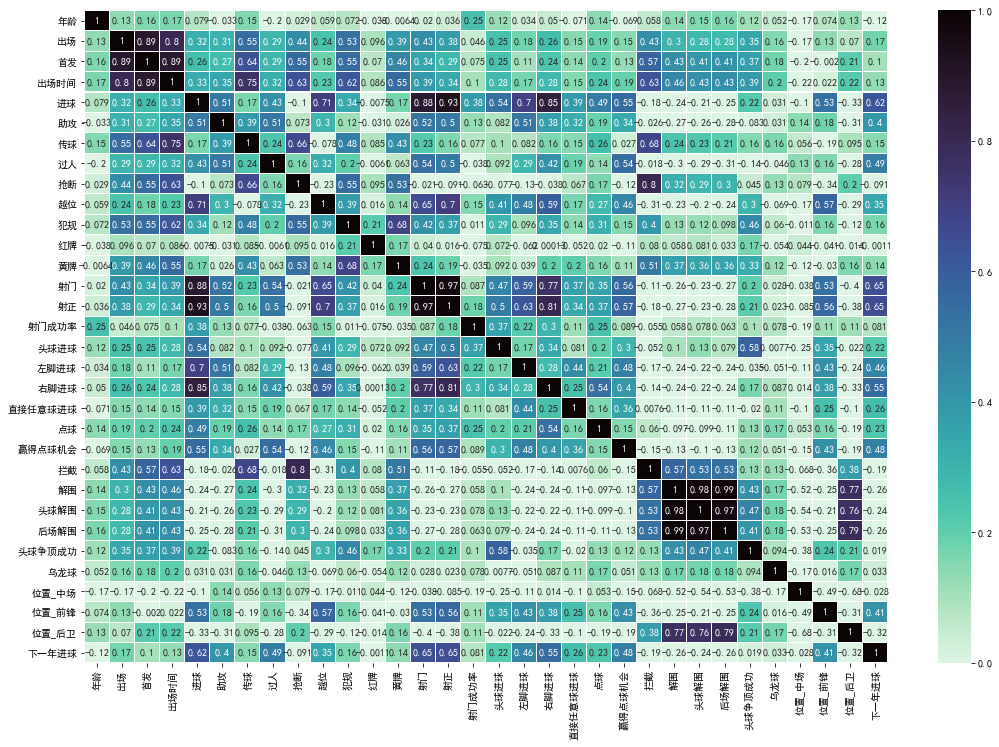

In [11]:
#使用相关系数矩阵观察变量相关关系
plt.figure(figsize=(18,12))
correlations = data_u.corr() 
correction=abs(correlations)# 取绝对值，可只看相关程度
# plot correlation matrix 
ax = sns.heatmap(correlations,cmap='mako_r', linewidths=0.05,vmax=1, vmin=0 ,annot=True,annot_kws={'size':10,'weight':'bold'})

#### 可看出：和下一年进球相关的变量 相关系数大于0.3的只有后卫是负的，别的都是正的

In [12]:
#再删一批和下一年进球相关性弱的变量(小于0.3)
data_u2=data_u.drop(columns=['年龄','出场','首发','出场时间','传球','抢断','犯规','红牌',
                             '黄牌','射门成功率','拦截','头球争顶成功','乌龙球','位置_中场','头球进球','直接任意球进球','点球','解围',
                            '头球解围','后场解围'])

### 2、主成分分析

In [13]:
#标准化
st = StandardScaler().fit_transform(data_u2)

B:\anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
B:\anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [14]:
df = pd.DataFrame(st)

In [15]:
df.columns = data_u2.columns

In [16]:
df.head(3)

,进球,助攻,过人,越位,射门,射正,左脚进球,右脚进球,赢得点球机会,位置_前锋,位置_后卫,下一年进球
0,-0.615240,-0.934601,-0.900383,-0.580076,-0.643928,-0.394883,-0.531257,-0.677698,1.169041,-0.469668,1.523155,-0.429089
1,1.391679,-0.156938,-0.670484,1.062441,1.386892,1.579534,0.861196,1.431638,-0.383446,-0.469668,-0.656532,0.850470
2,-0.615240,-0.545769,-0.900383,-0.374761,-0.482752,-0.552837,-0.531257,-0.677698,-0.383446,-0.469668,1.523155,-0.642349


In [17]:
#变量方差占比
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(df)
pca.explained_variance_ratio_

array([0.55184512, 0.09385994, 0.07377173, 0.06928187, 0.06165831,
       0.04849212, 0.03482454, 0.02705252, 0.02178377, 0.01378202])

In [18]:
sum(pca.explained_variance_ratio_[:3])

0.719476779602914

#### 注：前三个主成分的贡献度为0.719476779602914

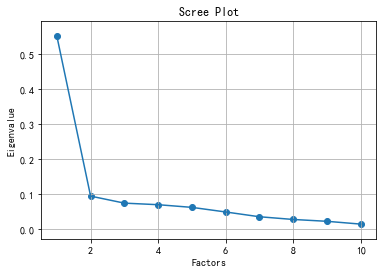

In [19]:
# 进行可视化
importance = pca.explained_variance_ratio_
plt.scatter(range(1,11),importance)
plt.plot(range(1,11),importance)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [20]:
# 进行降维,降到3维
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(df.iloc[:,:-1])#不带下一次进球列
# 查看降维后的数据
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2','principal component 3'])
finalDf = pd.concat([principalDf, df[['下一年进球']]], axis = 1)
finalDf.head(5)

,principal component 1,principal component 2,principal component 3,下一年进球
0,-1.701802,-0.417563,1.533565,-0.429089
1,2.385976,-1.003184,-0.866659,0.850470
2,-1.966005,-0.475935,0.903187,-0.642349
3,-2.202232,-0.358522,0.910031,-0.429089
4,2.452526,-1.019984,0.260494,-0.215829


In [21]:
#查看转换系数
pca.components_

array([[ 3.79338012e-01,  2.44518165e-01,  2.41149247e-01,
         3.08367973e-01,  3.77060631e-01,  3.85197192e-01,
         2.80646703e-01,  3.19440970e-01,  2.72157998e-01,
         2.50885214e-01, -1.86278571e-01],
       [-1.13269713e-01,  5.31234051e-01,  5.77581156e-01,
        -3.20084640e-01, -1.45408658e-02, -8.11324776e-02,
         1.98566786e-02, -9.26609702e-02,  1.35064327e-01,
        -4.76855338e-01, -8.65941211e-02],
       [ 2.39314359e-02,  2.86510904e-02,  2.44652395e-04,
         2.38644555e-02, -7.34500428e-02, -3.87732238e-02,
         4.36038530e-01, -3.22124221e-01,  4.12695064e-01,
         8.61025455e-02,  7.20773251e-01]])

Text(0.5, 1.0, 'PCA')

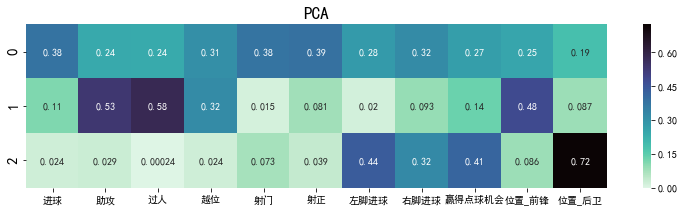

In [22]:
# 对系数进行可视化
df_cm = pd.DataFrame(np.abs(pca.components_), columns=df.columns[:-1])
plt.figure(figsize = (13,3))
ax = sns.heatmap(df_cm, annot=True,cmap="mako_r")
# 设置y轴的字体的大小
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=10)
plt.title('PCA', fontsize='xx-large')

分析：

在第一主成分上，占主要地位的是“进球”、“射门”、“射正”以及“右脚进球”，且都与进球正相关，故第一主成分可命名为——进球能力指数

在第二主成分上，占主要地位的是“助攻”、“过人”以及“位置_前锋”，且都与进球正相关，故第二主成分可命名为——进球机会指数

在第三主成分上，占主要地位的是“位置_后卫”，它与进球负相关，故第三主成分可命名为——位置不利因素

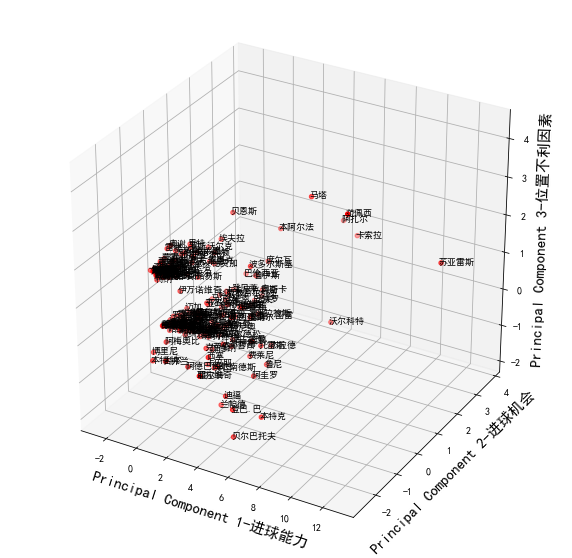

In [32]:
#第三维度是抑制性，一二维度是促进性
#画三维图形，所有球员在3个维度上的投影

fig = plt.figure(figsize=(10,10))
a = finalDf.iloc[:,0]
b = finalDf.iloc[:,1]
c = finalDf.iloc[:,2]
ax=plt.subplot(111,projection='3d') 
ax.scatter(a, b, c ,c="r")
ax.set_xlabel('Principal Component 1-进球能力', fontsize = 15)
ax.set_ylabel('Principal Component 2-进球机会', fontsize = 15)
ax.set_zlabel('Principal Component 3-位置不利因素', fontsize = 15)
for i,j,e,z in zip(a,b,c,data.iloc[:,0]):
    ax.text(x=i,y=j-0.1,z=e,s=z,fontsize=9)



从图中可看出，球员可被分为三类，分别为两团集聚点和集聚区外的个点，而这些个点中在三维上表现较好（1、2维上分数高，3维上分数低）的如苏亚雷斯、
沃尔科特、贝尔巴托夫等人均被证实是当时英超能力更为突出的球员

### 3、线性回归拟合

In [24]:
X_train,X_test, y_train, y_test  = train_test_split(finalDf.iloc[:,:3],finalDf.iloc[:,3],test_size=0.1, random_state=0)

In [25]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)   # 模型训练
lr.score(X_train, y_train) # 获取模型的得分

0.3705050950999933

In [26]:
lr.score(X_test, y_test)

0.6837249874181677

In [27]:
y_pred = lr.predict(X_test)

In [28]:
import statsmodels.api as sm
olsr = sm.OLS(y_pred, y_test).fit()
olsr.summary()

B:\anaconda\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
B:\anaconda\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     61.98
Date:                Sat, 09 Nov 2019   Prob (F-statistic):           6.82e-07
Time:                        21:04:23   Log-Likelihood:                -8.0940
No. Observations:                  17   AIC:                             18.19
Df Residuals:                      16   BIC:                             19.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
下一年进球          0.4977      0.063      7.873      0.000       0.364       0.632
==============================================================================
Omnibus:                        5.879   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                3.499
Skew:                           1.075   Prob(JB):                        0.174
Kurtosis:                       3.561   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
#若使用原来的高维数据
X_train2,X_test2, y_train2, y_test2  = train_test_split(data_u.iloc[:,:-1],data_u.iloc[:,-1],test_size=0.1, random_state=0)
lr.fit(X_train2,y_train2)   # 模型训练
lr.score(X_train2, y_train2) # 获取模型的得分

0.561295854873407

In [30]:
lr.score(X_test2, y_test2)

0.5494045677678177

In [31]:
y_pred2 = lr.predict(X_test2)
olsr2 = sm.OLS(y_pred2, y_test2).fit()
olsr2.summary()

B:\anaconda\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     43.96
Date:                Sat, 09 Nov 2019   Prob (F-statistic):           5.78e-06
Time:                        21:04:31   Log-Likelihood:                -36.373
No. Observations:                  17   AIC:                             74.75
Df Residuals:                      16   BIC:                             75.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
下一年进球          0.4369      0.066      6.631      0.000       0.297       0.577
==============================================================================
Omnibus:                        0.012   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.994   Jarque-Bera (JB):                0.161
Skew:                          -0.049   Prob(JB):                        0.923
Kurtosis:                       2.533   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

注：对比了之后可看出是有优化的，在测试集上主成分拟合得分0.68大于原数据拟合得分0.549，且R方0.795大于原数据的0.733